# Single Spectrum Analysis

Illustration de la méthode [SSA](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) pour les séries temporelles.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Une série articielle

In [3]:
import numpy.random as rnd
import numpy
N = 2000
bruit1 = rnd.normal(size=(N,))
temps = numpy.arange(N)
bruit1[:5], temps[:5]

(array([ 0.33023976,  0.8413997 ,  0.75384726,  0.18790701, -0.22188852]),
 array([0, 1, 2, 3, 4]))

In [4]:
serie = []
y = 10
for i in range(N//2+100):
    serie.append(y + bruit1[i] + 0.0004 * temps[i])
    if i > 30:
        y = 0.9 * serie[-2]
Y = numpy.array(serie[-1000:])
Y[:5]

array([3.47524189, 1.13495964, 3.70849384, 0.41777411, 3.99022154])

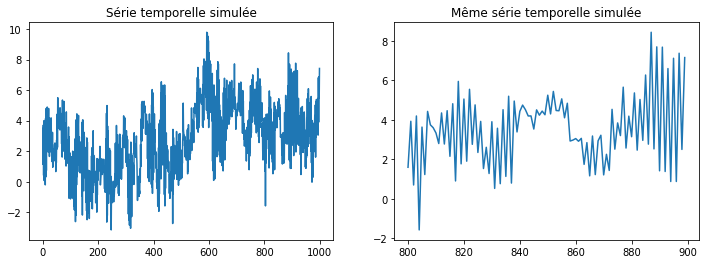

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(numpy.arange(len(Y)), Y)
ax[1].plot(numpy.arange(800, 900), Y[800:900])
ax[0].set_title("Série temporelle simulée")
ax[1].set_title("Même série temporelle simulée");

## Autocorrélation

In [6]:
from pandas import DataFrame
df = DataFrame(dict(Y=Y))
df.head()

,Y
0,3.475242
1,1.134960
2,3.708494
3,0.417774
4,3.990222


In [7]:
from statsmodels.tsa.tsatools import detrend
df["notrend"] = detrend(df.Y)
df.head()

,Y,notrend
0,3.475242,2.401798
1,1.134960,0.058044
2,3.708494,2.628107
3,0.417774,-0.666084
4,3.990222,2.902892


Text(0.5, 1.0, 'Sans tendance')

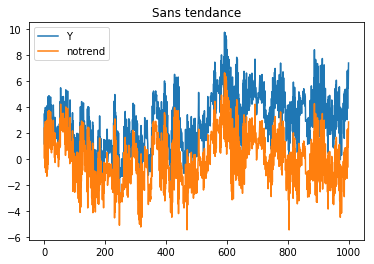

In [8]:
ax = df.plot()
ax.set_title("Sans tendance")

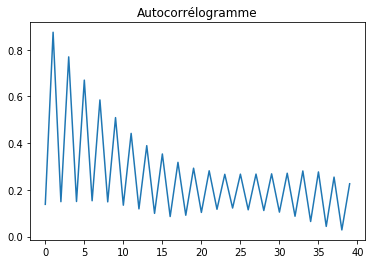

In [9]:
from statsmodels.tsa.stattools import acf
cor = acf(df.notrend)
fig, ax = plt.subplots(1, 1)
ax.plot(cor[1:])
ax.set_title("Autocorrélogramme");

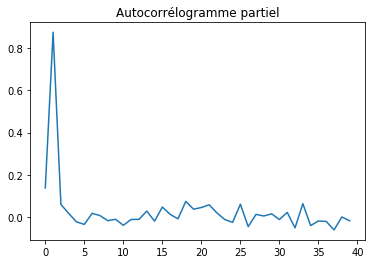

In [10]:
from statsmodels.tsa.stattools import pacf
pcor = pacf(df.notrend)
fig, ax = plt.subplots(1, 1)
ax.plot(pcor[1:])
ax.set_title("Autocorrélogramme partiel");

## SSA

In [11]:
def lagged_ts(serie, lag):
    dim = serie.shape[0]
    res = numpy.zeros((dim - lag + 1, lag))
    for i in range(lag):
        res[:, i] = serie[i:dim-lag+i+1]
    return res

lagged_ts(Y, 3)

array([[3.47524189, 1.13495964, 3.70849384],
       [1.13495964, 3.70849384, 0.41777411],
       [3.70849384, 0.41777411, 3.99022154],
       ...,
       [6.81643463, 3.8998291 , 6.86684167],
       [3.8998291 , 6.86684167, 5.50338294],
       [6.86684167, 5.50338294, 7.41606059]])

In [12]:
lag = lagged_ts(Y, 60)
lag.shape

(941, 60)

In [13]:
from numpy.linalg import svd
# ``u @ numpy.diag(s) @ vh
u, s, vh = svd(lag)

In [14]:
u.shape, s.shape, vh.shape

((941, 941), (60,), (60, 60))

In [15]:
d = numpy.zeros((941, 60))
d[:60,:60] = numpy.diag(s)

In [16]:
(u @ d @ vh).shape

(941, 60)

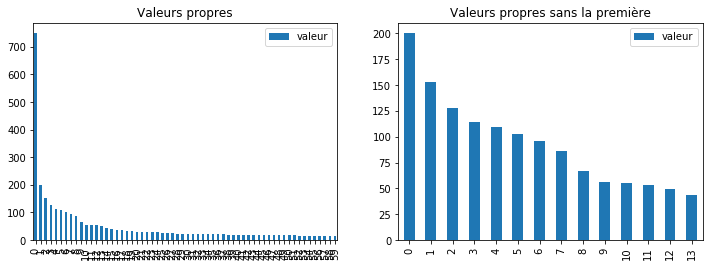

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
DataFrame(dict(valeur=s)).plot(kind="bar", ax=ax[0])
DataFrame(dict(valeur=s[1:15])).plot(kind="bar", ax=ax[1])
ax[0].set_title("Valeurs propres")
ax[1].set_title("Valeurs propres sans la première");

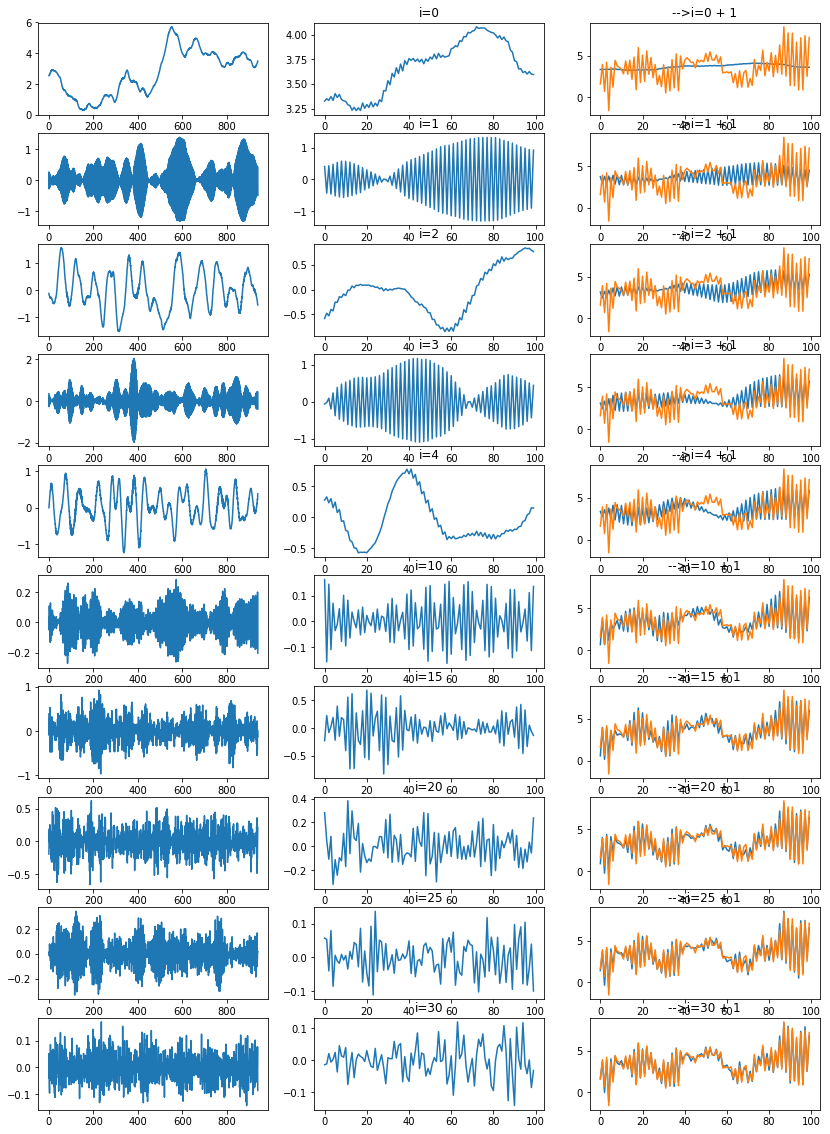

In [18]:
np = 10
fig, ax = plt.subplots(np, 3, figsize=(14, np*2))
for n in range(np):
    i = n if n < 5 else n * 5 - 15
    d = numpy.zeros((941, 60))
    d[i, i] = s[i]
    X2 = u @ d @ vh
    pos = 0 #X2.shape[1] - 1
    
    # série reconstruites avec un axe
    ax[n, 0].plot(X2[:,pos])
    ax[n, 1].set_title("i=%d" % i)    
    # série reconstruites avec un axe
    ax[n, 1].plot(X2[800:900,end])
    ax[n, 1].set_title("i=%d" % i)
    
    d = numpy.zeros((941, 60))
    d[:i+1, :i+1] = numpy.diag(s[:i+1])
    X2 = u @ d @ vh
    ax[n, 2].plot(X2[800:900,pos])    
    ax[n, 2].plot(Y[800:900])
    ax[n, 2].set_title("-->i=%d + 1" % i)